<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. Transfer Learning với TensorFlow Phần 2: Fine-tuning

Ở phần trước, chúng ta đã thấy cách tận dụng feature extraction transfer learning để đạt được kết quả tốt hơn cho project Food Vision so với việc xây dựng mô hình của riêng mình (với ít dữ liệu hơn).

Bây giờ chúng ta sẽ tìm hiểu một loại transfer learning khác: fine-tuning (tinh chỉnh).

Trong **fine-tuning transfer learning**, trọng số của pre-trained model từ mô hình khác bị ngưng hoạt động và được tinh chỉnh trong quá trình đó để phù hợp hơn với dữ liệu.

Với feature extraction transfer learning, bạn chỉ có thể huấn luyện 1-3 layer trên cùng của pre-trained model với dữ liệu của mình, còn trong fine-tuning transfer learning, có thể huấn luyện 1-3+ layer của pre-trained model (trong đó '+' thể hiện nhiều hoặc tất cả layer có thể huấn luyện).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning với fine-tuning transfer learning. Khác biệt chính ở đây là trong fine-tuning, nhiều layer của pre-trained model ngừng hoạt động và điều chỉnh dữ liệu tùy chỉnh. Fine-tuning này thường cần nhiều dữ liệu hơn so với feature extraction để được hiệu quả.*  

## Những điều chúng ta sẽ tìm hiểu

Chúng ta sẽ xem xét những điều sau với TensorFlow:

- Giới thiệu fine-tuning - một loại transfer learning chỉnh sửa pre-trained model để phù hợp với dữ liệu
- Sử dụng Keras Functional API (cách khác để xây dựng mô hình trong Keras)
- Sử dụng tập dữ liệu nhỏ hơn để thử nghiệm nhanh hơn (ví dụ: 1-10% mẫu huấn luyện của 10 lớp về đồ ăn)
- Data augmentation (cách khiến tập huấn luyện đa dạng hơn mà không cần thêm nhiều dữ liệu)
- Chạy một chuỗi các thử nghiệm lập mô hình trên dữ liệu Food Vision
  - Mô hình 0: mô hình transfer learning sử dụng Keras Functional API
  - Mô hình 1: mô hình feature extraction transfer learning trên 1% dữ liệu với data augmentation
  - Mô hình 2: mô hình feature extraction transfer learning trên 10% dữ liệu với data augmentation
  - Mô hình 3: mô hình fine-tuned transfer learning trên 10% dữ liệu
  - Mô hình 4: mô hình fine-tuned transfer learning trên 100% dữ liệu
- Giới thiệu ModelCheckpoint callback để lưu các kết quả huấn luyện trung gian
- So sánh các thử nghiệm mô hình sử dụng TensorBoard

## Cách sử dụng notebook này

Các bạn có thể đọc qua các mô tả và code (tất cả sẽ chạy, trừ những cell mắc lỗi có chủ đích), nhưng có một lựa chọn tốt hơn.
Tự viết toàn bộ code.

Nghiêm túc đấy. Hãy tạo notebook mới và tự viết lại từng dòng. Kiểm tra xem bạn có thể thay đổi nó không và lý do cho điều đó.

Bạn không cần viết mô tả bằng văn bản nhưng tự viết lại code là một cách tuyệt vời để có trải nghiệm thực tiễn.

Đừng lo lắng nếu mắc sai sót, ai cũng đều mắc lỗi cả. Cách thực hiện tốt hơn và mắc ít lỗi hơn là **viết nhiều code hơn**.

In [ ]:
# Chúng ta có đang sử dụng GPU không? (nếu không có và đang dùng Google Colab, tới Runtime -> Change Runtime Type -> Harware Accelerator: GPU )
!nvidia-smi

Tue Feb 16 02:14:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Tạo hàm hỗ trợ

Các bạn sẽ gặp những đoạn code cần lặp đi lặp lại trong các thử nghiệm ML.

Ví dụ: hàm vẽ object `history` của mô hình (xem `plot_loss_curves()` dưới đây).

Chúng ta có thể tạo lại các hàm này nhiều lần.

Nhưng các bạn thấy đấy, viết lại nhiều lần như vậy rất dài dòng.

Một trong các giải pháp là lưu chúng trong một hàm hỗ trợ như [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py), sau đó import chức năng cần thiết nếu cần.

Ví dụ, bạn có thể viết:

```
from helper_functions import plot_loss_curves

...

plot_loss_curves(history)
```

Hãy xem điều này trông như thế nào.

In [1]:
# Lấy helper_functions.py script từ khóa GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import hàm hỗ trợ mà chúng ta sẽ sử dụng
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-04-19 06:25:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-19 06:25:27 (24.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Tuyệt, chúng ta đã có nhiều hàm hỗ trợ để dùng trong suốt notebook mà không cần viết lại từ đầu mỗi lần.

> 🔑 **Lưu ý:** Nếu bạn đang chạy notebook này trong Google Colab, khi hết giờ Colab sẽ xóa file `helper_functions.py`. Do đó, để sử dụng các hàm đã import ở trên, cần chạy lại cell.

## 10 Food Classes: Làm việc với ít dữ liệu hơn

Ở [notebook trước](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb), chúng ta đã thấy rằng có thể thu được kết quả tốt hơn chỉ với 10% dữ liệu huấn luyện khi sử dụng transfer learning với TensorFlow Hub.

Trong notebook này, chúng ta sẽ tiếp tục làm việc với các tập dữ liệu con nhỏ hơn, trừ việc lần này chúng ta sẽ xem xét cách sử dụng các pretrained model được tích hợp trong mô-đun `tf.keras.applications` cũng như cách tinh chỉnh chúng với tập dữ liệu tùy chỉnh của chúng ta

Chúng ta cũng sẽ luyện tập với một hàm dataloader mới nhưng tương tự với hàm [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) chúng ta đã dùng trước đó, là một phần của mô-đun [`tf.keras.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing).

Cuối cùng, chúng ta sẽ luyện tập với [Keras Functional API](https://keras.io/guides/functional_api/) để xây dựng các mô hình deep learning. Functional API là cách tạo mô hình linh hoạt hơn so với tf.keras.Sequential API.

Chúng ta sẽ khám phá chi tiết từng thứ một.

Hãy bắt đầu bằng việc download một vài dữ liệu.

In [2]:
# Lấy 10% dữ liệu của 10 lớp
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-04-19 06:25:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.27, 172.217.7.59, 172.217.12.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   237MB/s    in 0.7s    

2024-04-19 06:25:50 (237 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



Tập dữ liệu mà chúng ta đang download là tập dữ liệu 10 food classes (từ Food 101) với 10% dữ liệu ảnh huấn luyện mà chúng ta đã dùng ở notebook trước.

> 🔑 **Lưu ý:** Các bạn có thể thấy cách tạo tập dữ liệu này trong [notebook image data modification](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).



In [6]:
#Xem qua directory 10% dữ liệu và liệt kê số file
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

Chúng ta có thể thấy mỗi training directory có 75 ảnh và mỗi test directory có 250 ảnh.

Hãy định nghĩa đường dẫn file huấn luyện và kiểm tra.

In [7]:
# Tạo các training/test directory
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Chúng ta đã có một số dữ liệu ảnh, cần load nó thành định dạng tương thích với TensorFlow.

Trước đó, chúng ta đã dùng lớp [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). dù nó hoạt động khá tốt và vẫn đang được sử dụng phổ biến nhưng lần này chúng ta sẽ dùng hàm `image_data_from_directory`.

Nó hoạt động khá tương tự với phương thức `flow_from_directory` của `ImageDataGenerator`, nghĩa là ảnh của bạn cần ở định dạng file sau:

```
Mẫu cấu trúc file

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

Một trong những lợi ích chính của việc sử dụng [`tf.keras.prepreprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) so với `ImageDataGenerator` là nó tạo đối tượng [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) thay vì tạo generator. Ưu điểm chính của điều này là API `tf.data.Dataset` hiệu quả hơn (nhanh hơn) so với API `ImageDataGenerator`, nó vô cùng quan trọng với các tập dữ liệu lớn hơn.

Hãy xem điều này thực tế thế nào.

In [8]:
# Tạo đầu vào dữ liệu
import tensorflow as tf
IMG_SIZE = (224, 224) # xác định size của ảnh
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # nhãn thuộc loại nào?
                                                                            batch_size=32) # batch_size mặc định là 32, đây thường là số tốt
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Tuyệt vời! Có vẻ các dataloader đã tìm thấy đúng số lượng ảnh cho mỗi tập dữ liệu.

Còn giờ chúng ta sẽ quan tâm tới các tham số chính trong hàm `image_dataset_from_directory()`:
* `directory` - filepath của directory mục tiêu mà chúng ta đang load ảnh từ đó.
* `image_size` - kích thước mục tiêu của các ảnh mà chúng ta đang load vào (chiều cao, chiều rộng).
* `batch_size` - kích thước batch của ảnh mà chúng ta đang load vào. Ví dụ: nếu `batch_size` là 32 (mặc định) thì batch của 32 ảnh và nhãn sẽ được truyền vào mô hình cùng một lúc.

Chúng ta có thể thử với nhiều thứ khác nếu muốn trong [tài liệu `tf.keras.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

Nếu chúng ta kiểm tra kiểu dữ liệu của dữ liệu huấn luyện sẽ thấy nó là `BatchDataset` có shape liên quan với dữ liệu của chúng ta.

In [9]:
# Kiểm tra kiểu dữ liệu của dữ liệu huấn luyện
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Trong đầu ra ở trên:

* `(None, 224, 224, 3)` đề cập tensor shape của ảnh, trong đó: `None` là kích thước batch, `224` là chiều cao (và chiều rộng) và `3` là kênh màu (red, green, blue).
* `(None, 10)` đề cập tensor shape của nhãn, trong đó: `None` là kích thước batch, `10` là số nhãn có thể (10 lớp thức ăn khác nhau).
* Cả image tensor và nhãn đều là kiểu dữ liệu `tf.float32`.

Bạn có thể coi `None` là placeholder đợi để điền với tham số `batch_size` từ `image_dataset_from_directory()`.

Một lợi ích khác của việc sử dụng API `tf.data.Dataset` là các phương thức liên kết đi kèm với nó.

Chẳng hạn: có thể dùng thuộc tính `class_names` nếu muốn tìm tên của các lớp mà chúng ta đang làm việc.

In [10]:
# Kiểm tra tên các lớp của tập dữ liệu
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Hoặc nếu muốn thấy ví dụ về batch dữ liệu, chúng ta có thể dùng phương thức `take()`.

In [11]:
# Xem ví dụ về batch của dữ liệu
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.18658157e+02 1.34658173e+02 1.34658173e+02]
   [1.18117348e+02 1.34117340e+02 1.34117340e+02]
   [1.19637756e+02 1.35637756e+02 1.35637756e+02]
   ...
   [5.63165398e+01 9.91634979e+01 9.18114929e+01]
   [6.20816345e+01 1.09224518e+02 1.03224518e+02]
   [6.39487991e+01 1.12260063e+02 1.08489639e+02]]

  [[1.06357147e+02 1.22357147e+02 1.21357147e+02]
   [1.09709190e+02 1.25709190e+02 1.24709190e+02]
   [1.12872452e+02 1.28872452e+02 1.27872452e+02]
   ...
   [6.32701912e+01 1.05913071e+02 9.67702332e+01]
   [6.22856750e+01 1.07270393e+02 1.02076508e+02]
   [5.61224899e+01 1.01571533e+02 9.63112946e+01]]

  [[9.16428604e+01 1.06071434e+02 1.05857147e+02]
   [9.68418427e+01 1.11270416e+02 1.11056129e+02]
   [1.00045921e+02 1.14474495e+02 1.14260208e+02]
   ...
   [8.43824387e+01 1.24550812e+02 1.16336548e+02]
   [7.37497177e+01 1.15162979e+02 1.08994621e+02]
   [2.96886349e+01 7.09029236e+01 6.69029236e+01]]

  ...

  [[7.94541016e+01 8.68878021e+01 8.90306473e+01]
   [8

Lưu ý cách các mảng ảnh xuất hiện tensor của các giá trị điểm ảnh, trong đó các nhãn xuất hiện ở dạng mã hóa one-hot (ví dụ: `[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]` cho `hamburger`).

### Mô hình 0: Xây dựng mô hình transfer learning với Keras Functional API

Dữ liệu đã được biến thành tensor, hãy xây dựng mô hình.

Để thực hiện, chúng ta sẽ sử dụng mô-đun [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) vì nó chứa một chuỗi các mô hình thị giác máy tính đã huấn luyện (trên ImageNet) cũng như Keras Functional API để tạo mô hình.

Chúng ta sẽ thực hiện các bước sau:

1. Khởi tạo đối tượng  pre-trained base model bằng cách chọn mô hình mục tiêu như [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) từ `tf.keras.applications`, thiết lập tham số `include_top` thành `False` (vì chúng ta sẽ tạo top của riêng mình, là layer đầu ra cho mô hình).
2. Thiết lập thuộc tính `trainable` của base model thành `False` để đóng băng toàn bộ trọng số trong pre-trained model.
3. Xác định layer đầu ra cho mô hình, chẳng hạn: shape của dữ liệu mà mô hình kỳ vọng là gì?
4. [Tùy chọn]  Chuẩn hóa đầu ra cho mô hình nếu cần. Một số mô hình thị giác máy tính như `ResNetV250` yêu cầu đầu ra trong khoảng 0-1.

> 🤔 **Lưu ý:** Khi viết, các mô hình `EfficientNet` trong mô-đun `tf.keras.applications` không yêu cầu ảnh phải được chuẩn hóa (các giá trị điểm ảnh trong khoảng 0-1) trên đầu ra trong khi nhiều mô hình khác lại yêu cầu. Tôi đã đăng [vấn đề này lên lên TensorFlow GitHub](https://github.com/tensorflow/tensorflow/issues/42506) và họ đã xác nhận nó.

5. Truyền các đầu vào cho base model.
6. Nhóm đầu ra của base model thành shape tương thích với layer kích hoạt đầu ra (biến base model output tensor thành shape tương tự như label tensor). Có thể thực hiện điều này bằng cách sử dụng [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) hoặc [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) dù `tf.keras.layers.GlobalAveragePooling2D()` được dùng phổ biến hơn.
7. Tạo layer kích hoạt đầu ra bằng cách sử dụng `tf.keras.layers.Dense()` với hàm kích hoạt và số nơ-ron thích hợp.
8. Kết hợp layer đầu  vào và đầu ra thành một mô hình bằng [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Biên dịch mô hình với hàm mất mát phù hợp và chọn thuật toán tối ưu.
10. Khớp mô hình cho số epoch mong muốn và với các callback cần thiết (trong trường hợp này, chúng ta sẽ bắt đầu với TensorBoard callback).

Có vẻ khá nhiều bước. Trước khi đi tiếp, hãy xem nó chạy thế nào.

In [12]:
# 1. Tạo mô hình với tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Đóng băng base model (nên các pattern đã tìm hiểu vẫn còn)
base_model.trainable = False

# 3. Tạo các đầu ra thành base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. Nếu đang sử dụng ResNet50V2, thêm nó để tăng tốc hội tụ, loại bỏ nếu dùng EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Truyền đầu vào cho base_model (lưu ý: dùng tf.keras.applications, đầu vào của EfficientNet không cần chuẩn hóa)
x = base_model(inputs)
# Kiểm tra shape dữ liệu sau khi truyền nó vào base_model
print(f"Shape after base_model: {x.shape}")

# 6. Gộp trung bình đầu ra của base model (tổng hợp tất cả những thông tin quan trọng nhất, giảm số lần tính toán)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Tạo layer kích hoạt đầu ra
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Kết hợp đầu vào với đầu ra thành một mô hình
model_0 = tf.keras.Model(inputs, outputs)

# 9. Biên dịch mô hình
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Khớp mô hình (sử dụng ít bước hơn cho validation nên nó nhanh hơn)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Đi qua ít dữ liệu kiểm định hơn nên các epoch nhanh hơn (chúng ta muốn thử nghiệm nhanh hơn!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Theo dõi nhật ký huấn luyện của mô hình cho các trực quan hóa sau này
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240419-062627
Epoch 1/5
24/24 [==============================] - 125s 5s/step - loss: 1.8459 - accuracy: 0.4573 - val_loss: 1.2567 - val_accuracy: 0.7599
Epoch 2/5
24/24 [==============================] - 134s 6s/step - loss: 1.0653 - accuracy: 0.7947 - val_loss: 0.8306 - val_accuracy: 0.8421
Epoch 3/5
24/24 [==============================] - 136s 6s/step - loss: 0.7704 - accuracy: 0.8400 - val_loss: 0.6669 - val_accuracy: 0.8586
Epoch 4/5
24/24 [==============================] - 104s 4s/step - loss: 0.6411 - accuracy: 0.8587 - val_loss: 0.6025 - val_accuracy: 0.8487
Epoch 5/5
24/24 [==============================] - 97s 4s/step - loss: 0.5443 - accuracy: 0.8827 - val_loss: 0.5195 - val_accuracy: 0.8783


Tuyệt! Sau khoảng một phút huấn luyện, mô hình của chúng ta đã thực hiện vô cùng tốt trên cả tập huấn luyện (độ chính xác trên 87%) và tập kiểm tra (độ chính xác ~83%).

Điều này rất đáng kinh ngạc, tất cả là nhờ khả năng của transfer learning.

Cần lưu ý loại transfer learning mà chúng ta dùng ở đây là feature extraction transfer learning, như những gì chúng ta thực hiện với các mô hình TensorFlow Hub.

Nói cách khác, chúng ta truyền dữ liệu tùy chỉnh vào pre-trained model (`EfficientNetB0`), hỏi nó "thấy những pattern nào" rồi đặt layer đầu ra lên đầu để đảm bảo đầu ra được điều chỉnh phủ hợp với số lớp mong muốn.

Chúng ta cũng sử dụng Keras Functional API để xây dựng mô hình của mình hơn là Sequential API. Lợi ích của điều này có vẻ không rõ ràng nhưng khi bắt đầu xây dựng mô hình phức tạp hơn, các bạn có thể sẽ muốn sử dụng Functional API. Nên việc tiếp xúc với cách xây dựng mô hình như vậy cũng quan trọng.

> 📖 **Tài liệu:** Xem [tài liệu về TensorFlow Functional API](https://www.tensorflow.org/guide/keras/functional) để biết các lợi ích và trường hợp sử dụng của Functional API với Sequential API.

ãy xem các layer trong mô hình của chúng ta, bắt đầu với base model.

In [13]:
# Kiểm tra các layer trong base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

Có nhiều layer... tự tay viết code chúng tốn khá nhiều thời gian thực hiện, nên chúng ta có thể tận dụng chúng nhờ khả năng của transfer learning.

Vậy còn summary của base model?

In [14]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

Các bạn có thể thấy mỗi layer khác nhau lại có số lượng tham số nhất định. Vì chúng ta đang sử dụng pre-trained model nên có thể coi tất cả các tham số này là pattern mà base model học được trên một tập dữ liệu khác. Và do chúng ta đã đặt `base_model.trainable = False` nên các pattern này vẫn giữ nguyên như khi chúng đang huấn luyện (chúng bị đóng băng và không được cập nhật).

Đó là base model, hãy xem summary của mô hình tổng thể.

In [15]:
# Kiểm tra summary của mô hình đã tạo với Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

Mô hình tổng thể có 5 layer, mỗi layer này (`efficientnetb0`) lại có 236 layer.

Các bạn có thể thấy output shape bắt đầu là `(None, 224, 224, 3)`  cho layer đầu vào (shape của ảnh) nhưng được biến đổi thành `(None, 10)` do layer đầu ra (shape của nhãn), trong đó `None` là placeholder cho batch size.

Các bạn cũng lưu ý những tham số chỉ có thể huấn luyện trong mô hình là các tham số trong layer đầu ra.

Training curve của mô hình trông như thế nào?



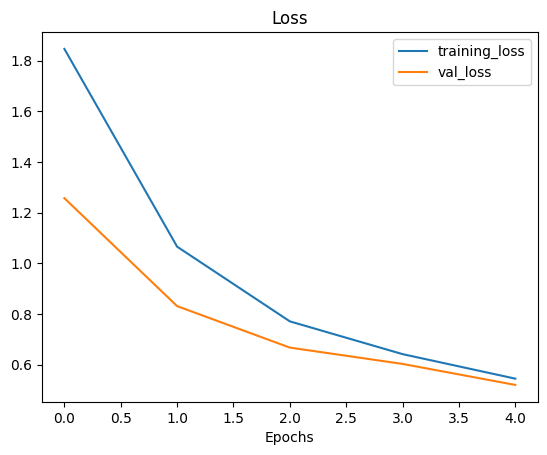

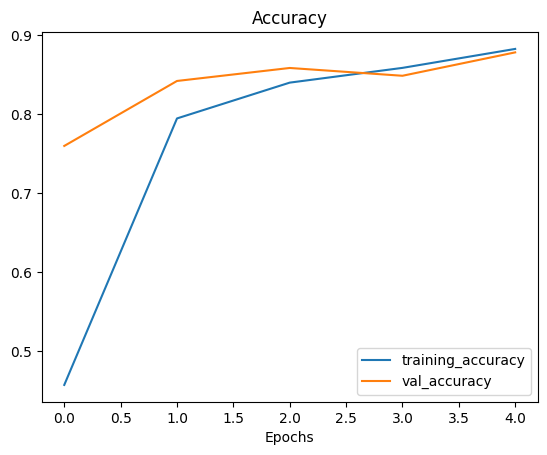

In [16]:
# Kiểm tra training curve của mô hình
plot_loss_curves(history_10_percent)

## Lấy vectơ đặc trưng từ mô hình đã huấn luyện

> 🤔 **Câu hỏi:** Điều gì xảy ra với layer `tf.keras.layers.GlobalAveragePooling2D()`? Tôi chưa từng thấy điều này trước đó.

Layer [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) biến đổi tensor 4D thành tensor 2D bằng cách tính trung bình các giá trị trên các trục bên trong.

Câu trước hơi khó hiểu, hãy xem ví dụ sau.

In [17]:
# Định nghĩa input tensor shape (có cùng số chiều như đầu ra của efficientnetb0)
input_shape = (1, 4, 4, 3)

# Tạo random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Truyền random tensor qua global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Kiểm tra shape của các tensor khác nhau
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


Các bạn sẽ thấy layer `tf.keras.layers.GlobalAveragePooling2D()` cô đặc tensor đầu vào từ shape `(1, 4, 4, 3)` thành `(1, 3)` bằng cách tính trung bình `input_tensor` qua hai trục ở giữa.

Chúng ta có thể sao chép hoạt động này với `tf.reduce_mean()` và chỉ định các trục thích hợp.

In [18]:
# Điều này tương tự như GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # tính trung bình qua các trục ở giữa

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

Thực hiện điều này không chỉ làm cho đầu ra của base model tương thích với yêu cầu về shape đầu ra của layer đầu ra (`tf.keras.layers.Dense()`) mà nó còn cô đặc thông tin mà base model tìm thấy thành **vectơ đặc trưng** ít chiều hơn.

> 🔑 **Lưu ý:** Một trong những nguyên nhân mà feature extraction transfer learning được đặt tên như vậy là vì pretrained model thường sẽ xuất ra **feature vector (vectơ đặc trưng)** (tensor dài gồm các số, trong trường hợp này, nó là đầu ra của layer [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)), sau đó nó được dùng để trích xuất ra các pattern.

> 🛠 **Luyện tập:** Thực hiện tương tự như cell trên nhưng cho [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

## Chạy một chuỗi các thử nghiệm transfer learning

Chúng ta đã thấy các kết quả đáng kinh ngạc của transfer learning trên 10% dữ liệu huấn luyện, vậy còn trên 1% dữ liệu huấn luyện thì sao?

Bạn nghĩ chúng ta sẽ thu được kết quả thế nào khi dùng ít hơn 100 lần dữ liệu so với mô hình CNN ban đầu mà chúng ta đã tự tạo?

Hãy trả lời các câu hỏi này trong khi chạy các thử nghiệm lập mô hình sau:
1. `model_1`: Sử dụng feature extraction transfer learning trên 1% dữ liệu huấn luyện với data augmentation.
2. `model_2`: Sử dụng feature extraction transfer learning trên 10% dữ liệu huấn luyện với data augmentation.
3. `model_3`: Sử dụng fine-tuning transfer learning trên 10% dữ liệu huấn luyện với data augmentation.
4. `model_4`: Sử dụng fine-tuning transfer learning trên 100% dữ liệu huấn luyện với data augmentation.

Trong khi tất cả các thử nghiệm trên sẽ chạy trên các phiên bản dữ liệu huấn luyện khác nhau, chúng đều sẽ được đánh giá trên cùng một tập kiểm tra, điều này đảm bảo kết quả của mỗi thử nghiệm có thể tương tự nhất có thể.

Tất cả các thử nghiệm sẽ được thực hiện bằng mô hình `EfficientNetB0` trong mô-đun `tf.keras.applications`.

Chúng ta sẽ dùng hàm `create_tensorboard_callback()` để ghi lại toàn bộ nhật ký huấn luyện của mô hình, đảm bảo chúng ta có thể theo dõi các thử nghiệm của mình.

Chúng ta sẽ tạo từng mô hình sử dụng Keras Functional API và thay vì triển khai data augmentation trong lớp `ImageDataGenerator` như chúng ta có trước đó, chúng ta sẽ xây dựng nó ngay trong mô hình nhờ mô-đun [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing).

Hãy bắt đầu bằng cách download dữ liệu cho thử nghiệm 1, sử dụng feature extraction transfer learning trên 1% dữ liệu huấn luyện với data augmentation.

In [19]:
# Download và giải nén dữ liệu
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Tạo các training/test dir
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2024-04-19 06:37:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.59, 172.217.12.27, 142.250.65.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   120MB/s    in 1.1s    

2024-04-19 06:37:37 (120 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



Chúng ta đang hoạt động với bao nhiêu ảnh?

In [ ]:
# Xem qua 1% directory dữ liệu và liệt kê số lượng file
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

Có vẻ chúng ta chỉ có 7 ảnh mỗi lớp, điều này khá thách thức với mô hình của chúng ta.

> 🔑 **Lưu ý:** Với 10% của tập dữ liệu con, sẽ có 1% ảnh được chọn ngẫu nhiên từ tập huấn luyện đầy đủ ban đầu. Các ảnh kiểm tra cũng tương tự như những cái mà chúng ta đã sử dụng trước đó. Xem [notebook về Food Vision Image Preprocessing](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) để biết cách tiền xử lý dữ liệu này.

Đã đến lúc laod ảnh trong đối tượng `tf.data.Dataset`, hãy dùng phương thức [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

In [34]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # mặc định
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Dữ liệu đã được load, hãy tăng cường nó.

### Thêm data augmentation ngay vào mô hình

Trước đó, chúng ta đã dùng các tham số khác nhau của lớp `ImageDataGenerator`  để tăng cường các ảnh huấn luyện, lần này chúng ta sẽ xây dựng data augmentation ngay vào mô hình.

Bằng cách nào?

Bằng cách sử dụng mô-đun [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) và tạo layer tăng cường dữ liệu chuyên dụng.

Đây là đặc trưng tương đối mới được thêm vào TensorFlow 2.2+ nhưng nó rất mạnh mẽ. Việc thêm layer tăng cường dữ liệu vào mô hình có những lợi ích sau:
* Tiền xử lý ảnh (tăng cường chúng) diễn ra trên GPU chứ không phải trên CPU (nhanh hơn).
  * Ảnh được tiền xử lý tốt nhất trên GPU trong khi dữ liệu văn bản và dữ liệu có cấu trúc thích hợp để tiền xử lý trên CPU hơn.
* Tăng cường dữ liệu hình ảnh chỉ diễn ra trong quá trình huấn luyện do đó chúng ta vẫn có thể xuất toàn bộ mô hình và sử dụng nó ở đâu đó. Và nếu ai đó khác muốn huấn luyện mô hình giống với mô hình của chúng ta, gồm kiểu tăng cường dữ liệu tương tự thì họ cũng có thể.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Ví dụ về việc sử dụng data augmentation làm layer đầu tiên trong một mô hình (EfficientNetB0).*

> 🤔 **Lưu ý:** Lúc viết, các layer tiền xử lý mà chúng ta dùng cho data augmentation sẽ ở trạng thái *thực nghiệm* trong thư viện TensorFlow. Điều này có nghĩa là mặc dù các layer có thể coi là ổn định thì code cũng có thể thay đổi một chút ở phiên bản TensorFlow tương lai. Để biết thêm thông tin về các layer tiền xử lý sẵn có khác và các phương pháp tăng cường dữ liệu khác nhau, hãy xem [hướng dẫn về Keras preprocessing layer](https://keras.io/guides/preprocessing_layers/) và [hướng dẫn về TensorFlow data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).

Để sử dụng data augmentation ngay trong mô hình, chúng ta sẽ tạo mô hình Keras Sequential chỉ có các layer tiền xử lý dữ liệu, sau đó dùng mô hình Sequential này trong một mô hình Functional khác.

Nghe có vẻ khó hiểu, nhưng điều này sẽ rõ ràng hơn khi chúng ta tạo trong code.

Chúng ta sẽ dùng các phép biến đổi data augmentation:
* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) - lật ảnh trên trục ngang hoặc trục dọc.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) - xoay ngẫu nhiên ảnh theo lượng đã chỉ định.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom) - phóng to ngẫu nhiên ảnh theo lượng đã chỉ định.
* [RandomHeight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomHeight) - thay đổi ngẫu nhiên chiều cao của ảnh theo lượng đã chỉ định.
* [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomWidth) - thay đổi ngẫu nhiên chiều rộng của ảnh theo lượng đã chỉ định.
* [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) - chuẩn hóa giá trị điểm ảnh thành giá trị trong khoảng 0-1, điều này đáng nói vì nó bắt buộc với một số mô hình ảnh nhưng khi chúng ta sử dụng triển khai `tf.keras.applications` của `EfficientNetB0` thì nó không còn bắt buộc nữa.

Có nhiều lựa chọn hơn nhưng bây giờ chúng ta sẽ thực hiện điều này.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Tạo data augmentation stage với horizontal flipping, rotation, zoom
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # giữ cho ResNet50V2, loại với EfficientNetB0
], name ="data_augmentation")

Chính là nó! Mô hình tuần tự tăng cường dữ liệu đã sẵn sàng. Ngay sau đó các bạn sẽ thấy chúng ta có thể sắp xếp "mô hình" này thành layer vào mô hình transfer learning sau.

Nhưng trước đó, hãy kiểm tra nó bằng cách truyền các ảnh ngẫu nhiên vào.

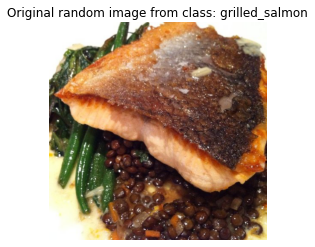

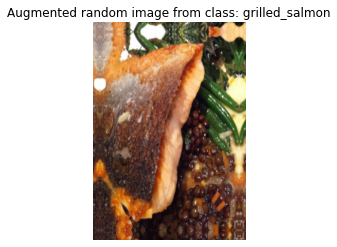

In [ ]:
# Xem ảnh ngẫu nhiên
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # chọn một class ngẫu nhiên
target_dir = "10_food_classes_1_percent/train/" + target_class # tạo directory đích
random_image = random.choice(os.listdir(target_dir)) # chọn một ảnh ngẫu nhiên từ directory đích
random_image_path = target_dir + "/" + random_image # tạo đường dẫn ảnh ngẫu nhiên đã chọn
img = mpimg.imread(random_image_path) # đọc trong ảnh mục tiêu đã chọn
plt.imshow(img) # vẽ ảnh mục tiêu
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn-off các trục

# Tăng cường ảnh
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # mô hình data augmentation yêu cầu shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # yêu cầu chuẩn hóa sau khi tăng cường
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

Chạy cell trên vài lần và bạn sẽ thấy các tăng cường ngẫu nhiên khác nhau ở các lớp ảnh khác nhau. Vì chúng ta sẽ thêm mô hình data augmentation làm layer trong mô hình transfer learning sắp tới nên nó sẽ áp dụng các kiểu tăng cường ngẫu nhiên này cho từng ảnh huấn luyện đi qua nó.

Điều này sẽ khiến tập huấn luyện đa dạng hơn một chút. Các bạn có thể coi như chúng ta đang chụp ảnh thức ăn trong thực tế, không phải tất cả các ảnh đều sẽ hoàn hảo nhưng một số trong chúng sẽ được định hướng theo các cách khác thường. Chúng là những loại ảnh mà chúng ta muốn mô hình xử lý.

Còn về mô hình, hãy xây dựng một mô hình với Functional API. Chúng ta sẽ chạy qua các bước tương tự như trước, trừ một điểm khác là chúng ta sẽ thêm mô hình tuần tự tăng cường dữ liệu làm layer ngay sau layer đầu vào.

## Mô hình 1: Feature extraction transfer learning trên 1% dữ liệu với data augmentation

In [ ]:
# Thiết lập shape đầu vào và base model, đóng băng các layer của base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Tạo layer đầu vào
inputs = layers.Input(shape=input_shape, name="input_layer")

# Thêm vào mô hình tuần tự tăng cường dữ liệu dưới dạng layer
x = data_augmentation(inputs)

# Cung cấp đầu vào cho base_model (sau khi tăng cường) và không huấn luyện nó
x = base_model(x, training=False)

# Gộp các đặc trưng đầu ra của base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Đặt dense layer làm đầu ra
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Tạo mô hình với đầu vào và đầu ra
model_1 = keras.Model(inputs, outputs)

# Biên dịch mô hình
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Khớp mô hình
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # xác thực cho ít bước hơn
                    # Theo dõi nhật ký huấn luyện mô hình
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210216-021736
Epoch 1/5
3/3 [==============================] - 10s 2s/step - loss: 2.4533 - accuracy: 0.0299 - val_loss: 2.2204 - val_accuracy: 0.1645
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1931 - accuracy: 0.0897 - val_loss: 2.0827 - val_accuracy: 0.2796
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9338 - accuracy: 0.4006 - val_loss: 1.9872 - val_accuracy: 0.3536
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8485 - accuracy: 0.4954 - val_loss: 1.8808 - val_accuracy: 0.4095
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.7186 - accuracy: 0.5845 - val_loss: 1.7857 - val_accuracy: 0.5099


Thật thú vị! Chỉ với 7 ảnh huấn luyện mỗi lớp, việc dùng transfer learning giúp mô hình của chúng ta đạt được độ chính xác ~40% trên tập kiểm định. Kết quả này rất đáng ngạc nhiên vì [tài liệu Food-101 ban đầu](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) thu được độ chính xác 50.67% với toàn bộ dữ liệu gồm 750 ảnh huấn luyện mỗi lớp (**lưu ý:** phép đo này là trên 101 lớp chứ không phải 10 lớp, chúng ta sẽ đo trên 101 lớp sau.)

Nếu kiểm tra summary của mô hình, chúng ta sẽ thấy layer tăng cường dữ liệu chỉ sau layer đầu vào.

In [ ]:
# Kiểm tra summary của mô hình
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Đây rồi. Data augmentation đã được xây dựng ngay trong mô hình của chúng ta. Điều này nghĩa là nếu chúng ta lưu và load lại nó ở một nơi khác thì lớp tăng cường dữ liệu sẽ xuất hiện kèm với nó.

Cần nhớ rằng **data augmentation chỉ chạy trong quá trình huấn luyện**. Do đó nếu muốn đánh giá hoặc sử dụng mô hình để suy luận (dự đoán lớp của ảnh) thì layer tăng cường dữ liệu sẽ tự động bị tắt.

Để xem điều này hoạt động ra sao, hãy đánh giá mô hình trên dữ liệu kiểm tra.

In [ ]:
# Đánh giá trên dữ liệu kiểm tra
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 10s 122ms/step - loss: 1.8055 - accuracy: 0.4728


[1.8054912090301514, 0.47279998660087585]

Kết quả ở đây có thể tốt hơn/kém hơn một chút so với đầu ra nhật ký của mô hình trong quá trình huấn luyện vì trong quá trình huấn luyện, chúng ta chỉ đánh giá mô hình trên 25% dữ liệu kiểm tra với dòng `validation_steps=int(0.25 * len(test_data))`. Điều này tăng tốc các epoch nhưng vẫn giúp chúng ta nắm được cách mô hình hoạt động.

Hãy kiểm tra loss curve của mô hình.

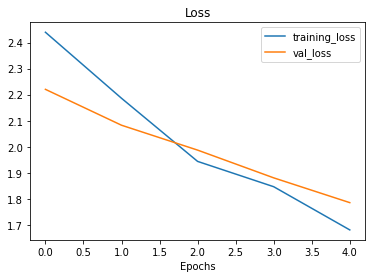

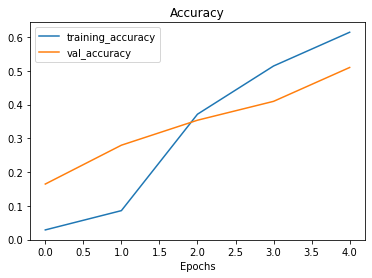

In [ ]:
# Mô hình hoạt động thế nào với layer tăng cường dữ liệu chỉ có 1% dữ liệu
plot_loss_curves(history_1_percent)

Có vẻ các phép đo trên cả hai tập dữ liệu đều sẽ cải thiện nếu chúng ta tiếp tục huấn luyện cho nhiều epoch hơn. Nhưng hãy bỏ qua điều đó, chúng ta còn nhiều phép thử hơn cần thực hiện!

## Mô hình 2: Feature extraction transfer learning với 10% dữ liệu và data augmentation

Chúng ta đã kiểm tra 1% dữ liệu huấn luyện với data augmentation, hãy thử 10% dữ liệu với data augmentation.

Nhưng đợi đã...

> 🤔 **Câu hỏi:** Làm sao để biết những thử nghiệm nào sẽ chạy?

Câu hỏi hay đấy.

Thật ra chúng ta thường không biết. Machine Learning vẫn còn đang được chạy thử nghiệm. Chỉ sau khi thử một vài thứ chúng ta mới bắt đầu có trực giác về những thứ cần làm.

Lời khuyên của tôi là hãy kiên trì theo sự tò mò nhất có thể. Nếu bạn muốn thử điều gì thì hãy viết code cho nó và chạy thôi, rồi xem điều gì sẽ xảy ra. Kết quả tệ nhất là bạn sẽ tìm ra những thứ không hoạt động, đây là vốn kiến thức khá giá trị.

Từ góc độ thực tế, như chúng ta đã đề cập trước đó, các bạn cần giảm thời gian nhiều nhất có thể giữa các thử nghiệm ban đầu. Nói cách khác, hãy chạy nhiều thử nghiệm nhỏ hơn, dùng ít dữ liệu hơn và ít lần lặp lại quá trình huấn luyện hơn trước khi tìm thấy thứ gì có triển vọng và rồi mở rộng nó.

Về chủ đề mở rộng, hãy mở rộng tỷ lệ thử nghiệm tăng cường dữ liệu huấn luyện 1% lên 10%.  Có thể câu này chưa rõ ràng lắm nhưng các bạn hiểu ý tôi mà.

Chúng ta sẽ chạy qua các bước giống ý hệt như trong mô hình ở trên, chỉ khác là chúng ta sẽ dùng 10% dữ liệu huấn luyện thay vì 1%.

In [ ]:
# Lấy 10% dữ liệu của 10 lớp (không chú thích nếu chưa có  "10_food_classes_10_percent.zip")
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Dữ liệu đã được download. Hãy tạo dataloader.

In [ ]:
# Thiết lập đầu vào dữ liệu
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Lưu ý: dữ liệu kiểm tra tương tự như trong thử nghiệm trước, chúng ta có thể
# bỏ qua việc tạo điều này nhưng hãy để đây để thực hành.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Thật kinh ngạc! Chúng ta làm việc với lượng ảnh nhiều hơn gấp 10 lần, 75 ảnh mỗi lớp thay vì 7 ảnh mỗi lớp.

Hãy xây một mô hình đã tích hợp data augmentation. Chúng ta có thể tái sử dụng mô hình tuần tự tăng cường dữ liệu đã tạo trước đó nhưng hãy tạo lại để luyện tập.

In [ ]:
# Tạo mô hình functional với data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Xây dựng layer tăng cường dữ liệu
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # giữ cho ResNet50V2, loại khỏi EfficientNet
], name="data_augmentation")

# Thiết lập shape đầu vào cho mô hình
input_shape = (224, 224, 3)

# Tạo base model đã đóng băng
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Tạo các layer đầu vào và đầu ra
inputs = layers.Input(shape=input_shape, name="input_layer") # tạo layer đầu vào
x = data_augmentation(inputs) # tăng cường ảnh huấn luyện
x = base_model(x, training=False) # truyền các ảnh đã tăng cường vào base model nhưng giữ nó ở chế độ suy luận, nên các batchnorm layer không cập nhật: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Biên dịch
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # sử dụng thuật tóa tối ưu Adam với learning rate cơ sở
              metrics=["accuracy"])

### Tạo ModelCheckpoint callback

Mô hình đã được biên dịch và sẵn sàng để khớp, vậy sao chúng ta chưa khớp nó?

Với thử nghiệm này, chúng ta sẽ đề xuất một callback mới là `ModelCheckpoint` callback.

[`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback cung cấp khả năng lưu toàn bộ mô hình ở định dạng [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) hoặc [chỉ trọng số (pattern)](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) vào directory đã chỉ định khi nó huấn luyện.

Điều này hữu ích nếu bạn nghĩ mô hình sẽ được huấn luyện lâu và muốn sao lưu mô hình khi nó huấn luyện. Điều này cũng có nghĩa là nếu bạn nghĩ mô hình có lợi từ việc huấn luyện lâu hơn, thì bạn có thể load lại mô hình từ checkpoint cụ thể và tiếp tục huấn luyện từ đó.

Ví dụ: giả sử bạn khớp mô hình feature extraction transfer learning cho 5 epoch, kiểm tra training curve và thấy nó vẫn đang cải thiện và muốn xem liệu tinh chỉnh thêm 5 epoch khác có giúp ích gì không thì có thể load checkpoint, phá đông một số (hoặc toàn bộ) layer của base model rồi tiếp tục huấn luyện.

Đây thực tế là những gì mà chúng ta sẽ làm.

Nhưng trước hết, hãy tạo `ModelCheckpoint` callback bằng cách chỉ định directory để lưu.

In [37]:
# Thiết lập đường dẫn checkpoint
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # lưu ý: nhớ rằng việc lưu trực tiếp vào Colab chỉ là tạm thời

# Tạo ModelCheckpoint callback chỉ để lưu các trọn số của mô hình
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # đặt là False để lưu toàn bộ mô hình
                                                         save_best_only=False, # đặt là True để chỉ lưu những mô hình tốt nhất thay vì một mô hình mỗi epoch
                                                         save_freq="epoch", # lưu mọi epoch
                                                         verbose=1)

> 🤔 **Câu hỏi:** Việc lưu toàn bộ mô hình (định dạng SavedModel) và chỉ lưu các trọng số khác nhau thế nào?

Định dạng [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) lưu toàn bộ kiến trúc, trọng số và cấu hình huấn luyện của một mô hình trong một folder, giúp dễ dàng load lại mô hình một cách chính xác bất kể nó ở đâu. Tuy nhiên, nếu không muốn chia sẻ tất cả những chi tiết này với người khác, bạn có thể lưu và chỉ chia sẻ trọng số (chúng chỉ là các tensor lớn, những số mà con người không hiểu được). Nếu vấn đề là dung lượng ổ đĩa thì chỉ lưu trọng số sẽ nhanh hơn và tốn ít dung lượng hơn so với lưu toàn bộ mô hình.

Đã đến lúc khớp mô hình.

Vì chúng ta sẽ tinh chỉnh nó sau đó nên hãy tạo biến `initial_epochs` và đặt nó thành 5 để sử dụng sau.

Chúng ta cũng sẽ thêm `checkpoint_callback` trong danh sách `callbacks`.

In [ ]:
# Khớp mô hình lưu checkpoint mỗi epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # thực hiện ít bước hơn mỗi validation (nhanh hơn)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210216-021854
Epoch 1/5
24/24 [==============================] - 16s 452ms/step - loss: 2.1809 - accuracy: 0.2156 - val_loss: 1.5099 - val_accuracy: 0.6299

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 9s 358ms/step - loss: 1.4534 - accuracy: 0.6360 - val_loss: 1.0699 - val_accuracy: 0.7582

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 9s 375ms/step - loss: 1.0684 - accuracy: 0.7427 - val_loss: 0.8586 - val_accuracy: 0.7878

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 8s 338ms/step - loss: 0.9191 - accuracy: 0.7720 - val_loss: 0.7781 - val_accuracy: 0.7993

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24

Có vẻ `ModelCheckpoint` callback đã hoạt động và mô hình của chúng ta đã lưu các trọng số của nó mỗi epoch mà không tốn quá nhiều chi phí (lưu toàn bộ mô hình lâu hơn so với chỉ lưu trọng số).

Hãy đánh giá mô hình và kiểm tra loss curve của nó.

In [ ]:
# Đánh giá trên dữ liệu kiểm tra
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 10s 119ms/step - loss: 0.7047 - accuracy: 0.8080


[0.7046541571617126, 0.8080000281333923]

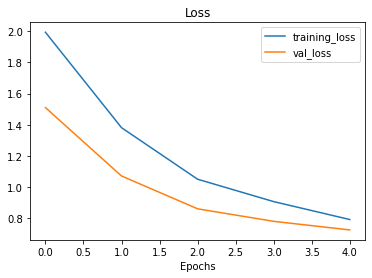

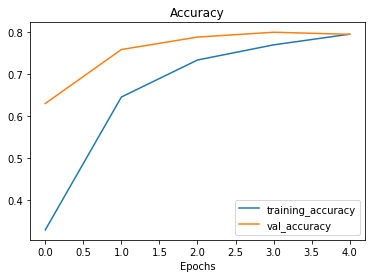

In [ ]:
# Vẽ các loss curve của mô hình
plot_loss_curves(history_10_percent_data_aug)

Qua các biểu đồ trên, chất lượng của mô hình với 10% dữ liệu và data augmentation không tốt như mô hình với 10% dữ liệu mà không có data augmentation (xem kết quả của `model_0` ở trên), tuy nhiên các đường cong đang đi đúng hướng, tức là các phép đo có thể sẽ cải thiện nếu chúng ta định huấn luyện lâu hơn.

Do chúng ta đã checkpoint các trọng số của mô hình nên chúng ta có thể thấy nó trông như thế nào khi load lại. Chúng ta có thể kiểm tra xem liệu nó có lưu đúng không bằng cách đánh giá trên dữ liệu kiểm tra.

Để load các trọng số của mô hình, chúng ta sẽ dùng phương thức [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options), truyền nó vào đường dẫn nơi lưu trữ các trọng số của bạn.

In [ ]:
# Load trọng số của mô hình đã lưu và đánh giá mô hình
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 10s 118ms/step - loss: 0.7047 - accuracy: 0.8080



Giờ hãy so sánh kết quả của mô hình đã huấn luyện trước đo và mô hình đã load. Các kết quả này rất gần nhau, không hoàn toàncon số đã được tính toán.

In [ ]:
# Nếu kết quả từ mô hình gốc và các trọng số đã load giống nhau, điều này sẽ xuất ra True
results_10_percent_data_aug == loaded_weights_model_results

False

Nếu cell trên không xuất ra `True` thì đó là do các số gần nhau nhưng không *hoàn toàn* giống nhau (do cách máy tính lưu trữ con số với các mức độ chính xác)

Tuy nhiên, chúng *rất* gần nhau...

In [ ]:
import numpy as np
# Kiểm tra xem liệu kết quả của mô hình đã load có rất gần với kết quả của mô hình ban đầu không (nên xuất ra True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Kiểm tra hiệu số giữa hai kết quả
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


## Mô hình 3: Tinh chỉnh mô hình hiện có với 10% dữ liệu

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*Ví dụ cấp cao về tinh chỉnh trên mô hình EfficientNet. Các layer dưới cùng (layer gần hơn với dữ liệu đầu vào) vẫn bị đóng băng trong khi các layer trên cùng (layer gần hơn với dữ liệu đầu ra) được cập nhật trong quá trình huấn luyện.*

Cho tới giờ mô hình đã lưu được huấn luyện với feature extraction transfer learning cho 5 epoch trên 10% dữ liệu huấn luyện và data augmentation.

Điều này nghĩa là tất cả các layer trong base model (EfficientNetB0) đều bị đóng băng trong quá trình huấn luyện.

Ở thử nghiệm tiếp theo, chúng ta sẽ chuyển sang fine-tuning transfer learning, nghĩa là chúng ta sẽ sử dụng base model tương tự, trừ việc chúng ta sẽ phá băng một số layer của nó (những layer gần nhất với trên cùng) và chạy mô hình cho vài epoch.

Ý tưởng với fine-tuning là bắt đầu tùy chỉnh thêm pre-trained model với dữ liệu của chúng ta.

> 🔑 **Lưu ý:** Fine-tuning thường hoạt động tốt nhất *sau khi* huấn luyện mô hình feature extraction cho một vài epoch và với lượng lớn dữ liệu. Xem [hướng dẫn của Keras về Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/) để tìm hiểu thêm.

Chúng ta đã xác minh chất lượng của mô hình, hãy kiểm tra các layer của nó.

In [ ]:
# Các layer trong mô hình đã load
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


Trông tốt đấy. Chúng ta đã có input layer, Sequential layer (mô hình data augmentation), Functional layer (EfficientNetB0), pooling layer và Dense layer (layer đầu ra).

Vậy còn summary?

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Có vẻ tất cả các layer trong layer `efficientnetb0` đều bị đóng băng. Chúng ta có thể xác nhận điều này với thuộc tính `trainable_variables`.

In [ ]:
# Có bao nhiêu layer có thể huấn luyện trong base model của chúng ta?
print(len(model_2.layers[2].trainable_variables)) # layer ở chỉ mục 2 là EfficientNetB0 layer (base model)

0


Điều này tương tự với base model của chúng ta.

In [ ]:
print(len(base_model.trainable_variables))

0


Có thể kiểm tra từng layer để xem chúng có thể huấn luyện không.

In [ ]:
# Kiểm tra xem những layer nào có thể điều chỉnh (có thể huấn luyện)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Đây chính xác là những gì chúng ta đang theo đuổi.

Bây giờ để tinh chỉnh base model với dữ liệu, chúng ta sẽ phá băng 10 layer trên cùng và tiếp tục huấn luyện mô hình cho 5 epoch khác.

Điều này nghĩa là trừ 10 layer trước đã đề cập, tất cả các layer của base model vẫn sẽ bị đóng băng và không thể huấn luyện. Và các trọng số ở các layer chưa bị đóng băng còn lại sẽ được cập nhật trong quá trình huấn luyện.

Chúng ta sẽ thấy chất lượng của mô hình cải thiện.

> 🤔 **Câu hỏi:** Chúng ta nên phá băng bao nhiêu layer trong khi huấn luyện?

Không có quy tắc nào cho điều này. Bạn có thể phá băng mọi layer trong pretrained model hoặc thử phá băng lần lượt từng layer. Tốt nhất là thử với số lượng phá băng và tinh chỉnh khác nhau để xem điều gì sẽ xảy ra. Nhìn chung, càng có ít dữ liệu thì bạn sẽ muốn phá băng ít layer hơn và dần dần muốn tinh chỉnh.

> 📖 **Tài liệu:** Tài liệu [ULMFiT (Universal Language Model Fine-tuning for Text Classification)](https://arxiv.org/abs/1801.06146) có một loạt các thử nghiệm về mô hình fine-tuning.

Để bắt đầu tinh chỉnh, chúng ta sẽ phá băng toàn bộ base model bằng cách thiết lập thuộc tính `trainable` thành `True`. Sau đó, chúng ta sẽ đóng băng lại mỗi lớp trong base model trừ 10 lớp cuối bằng cách lặp qua chúng và đặt thuộc tính `trainable` thành `False`. Cuối cùng, chúng ta sẽ biên dịch lại mô hình.

In [ ]:
base_model.trainable = True

# Đóng băng tất cả các layer trừ
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Biên dịch lại mô hình (luôn biên dịch lại sau bất cứ điều chỉnh nào cho mô hình)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr thấp hơn 10 lần so với trước khi fine-tuning
              metrics=["accuracy"])

Giờ hãy kiểm tra xem những layer nào của pretrained model có thể huấn luyện.

In [ ]:
# Kiểm tra xem những layer nào có thể điều chỉnh (có thể huấn luyện)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Có vẻ trừ 10 layer cuối, tất cả các layer đều bị đóng băng và không thể huấn luyện. Điều này tức là chỉ có 10 layer cuối của base model cùng với layer đầu ra được cập nhật trọng số trong quá trình huấn luyện.

> 🤔 **Câu hỏi:** Tại sao chúng ta biên dịch lại mô hình?

Mỗi lần thực hiện thay đổi mô hình, chúng ta đều phải biên dịch lại.

Trong trường hợp này, chúng ta đang sử dụng cùng chính xác cùng một loss, optimizer và các metrics như trước đó, ngoại trừ lần này learning rate cho optimizer sẽ nhỏ hơn 10 lần so với trước (0.0001 thay vì 0.001 mặc định của Adam).

Thực hiện như vậy để mô hình không cố gắng ghi đè các trọng số hiện có trong pretrained model quá nhanh. Nói cách khác, chúng ta muốn học dần dần.

> 🔑 **Lưu ý:** Không có tiêu chuẩn thiết lập nào cho learning rate trong quá trình fine-tuning mặc dù việc giảm [2.6x-10x+ dường như có tác dụng trong thực tế](https://arxiv.org/abs/1801.06146).

Bây giờ chúng ta có bao nhiêu biến có thể huấn luyện?

In [ ]:
print(len(model_2.trainable_variables))

12


Có vẻ mô hình của chúng ta có tổng cộng 10 biến có thể huấn luyện, 10 layer cuối cùng của base model, trọng số và các tham số độ chệch của dense output layer.

Đã đến lúc tinh chỉnh rồi!

Chúng ta sẽ tiếp tục huấn luyện từ chỗ mà mô hình trước hoàn thành. Vì nó huấn luyện cho 5 epoch nên fine-tuning của chúng ta sẽ bắt đầu từ epoch 5 và tiếp tục 5 epoch khác.

Chúng ta có thể sử dụng tham số `initial_epoch` của phương thức [`fit()`](https://keras.rstudio.com/reference/fit.html) để thực hiện điều này, truyền vào epoch cuối trong lịch sử huấn luyện của mô hình trước đó

In [ ]:
# Tinh chỉnh 5 epoch khác
fine_tune_epochs = initial_epochs + 5

# Khớp lại mô hình (tương tự model_2, ngoại trừ nhiều layer có thể huấn luyện hơn)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # bắt đầu từ epoch cuối trước đó
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # đặt tên thử nghiệm thích hợp

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210216-022051
Epoch 5/10
24/24 [==============================] - 15s 439ms/step - loss: 0.6963 - accuracy: 0.8062 - val_loss: 0.6032 - val_accuracy: 0.8043
Epoch 6/10
24/24 [==============================] - 8s 329ms/step - loss: 0.5747 - accuracy: 0.8390 - val_loss: 0.5580 - val_accuracy: 0.8125
Epoch 7/10
24/24 [==============================] - 8s 319ms/step - loss: 0.4972 - accuracy: 0.8458 - val_loss: 0.5543 - val_accuracy: 0.8240
Epoch 8/10
24/24 [==============================] - 8s 323ms/step - loss: 0.4262 - accuracy: 0.8814 - val_loss: 0.5403 - val_accuracy: 0.8191
Epoch 9/10
24/24 [==============================] - 8s 300ms/step - loss: 0.4234 - accuracy: 0.8855 - val_loss: 0.5262 - val_accuracy: 0.8322
Epoch 10/10
24/24 [==============================] - 8s 305ms/step - loss: 0.3665 - accuracy: 0.9056 - val_loss: 0.5218 - val_accuracy: 0.8322


> 🔑 **Lưu ý:** Fine-tuning thường tốn thời gian lâu hơn mỗi epoch so với feature extraction (do cập nhật nhiều trọng số hơn trong mạng).

Có vẻ mô hình của chúng ta đã tăng một vài điểm về độ chính xác. Hãy đánh giá nó.

In [ ]:
# Đánh giá mô hình trên dữ liệu kiểm tra
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 10s 117ms/step - loss: 0.4870 - accuracy: 0.8388


Các kết quả từ việc đánh giá mô hình có thể khác với đầu ra của việc huấn luyện do trong quá trình huấn luyện chúng ta chỉ đánh giá trên 25% dữ liệu kiểm tra.

Chúng ta cần một cách đánh giá chất lượng của mô hình trước và sau fine-tuning. Có nên viết hàm so sánh trước và sau không?

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    So sánh hai đối tượng history của mô hình.
    """
    # Lấy các phép đo original history
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Kết hợp original history với new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Tạo biểu đồ
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # dịch chuyển lại biểu đồ quanh các epoch
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # dịch chuyển lại biểu đồ quanh các epoch
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

Đây là lúc các biến history của mô hình huấn luyện hữu ích. Hãy xem điều gì xảy ra sau khi tinh chỉnh 10 layer cuối của mô hình.

5
11
[0.3293333351612091, 0.6453333497047424, 0.7333333492279053, 0.7693333625793457, 0.7946666479110718, 0.8026666641235352, 0.8320000171661377, 0.846666693687439, 0.8613333106040955, 0.8893333077430725, 0.8893333077430725]


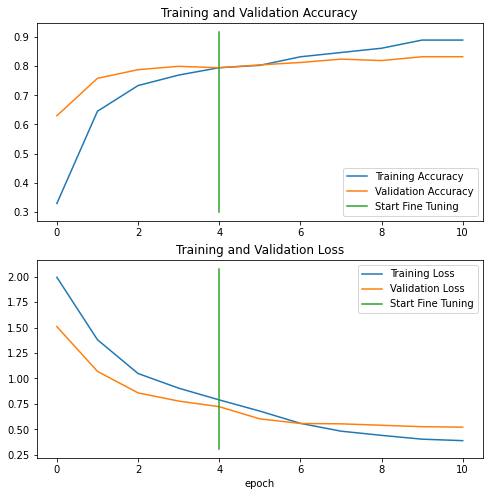

In [ ]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

Có vẻ các đường cong đang đi đúng hướng sau khi tinh chỉnh. Nhưng cần lưu ý rằng fine-tuning thường hoạt động tốt nhất với lượng dữ liệu lớn hơn.

## Mô hình 4: Fine-tuning mô hình có sẵn với toàn bộ dữ liệu

Chúng ta đã nói khá nhiều về fine-tuning mô hình thường hoạt động với nhiều dữ liệu hơn, hãy thử.

Chúng ta sẽ bắt đầu bằng cách download phiên bản đầy đủ của tập dữ liệu 101 food classes.



In [ ]:
# Download và giải nén 10 lớp dữ liệu với toàn bộ ảnh
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Thiết lập directory dữ liệu
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2021-02-16 02:48:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.253.115.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   124MB/s    in 4.1s    

2021-02-16 02:48:35 (121 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Chúng ta đang làm việc với bao nhiêu ảnh?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

Giờ chúng ta sẽ biến ảnh thành các tập dữ liệu tensor.

In [ ]:
# Thiết lập đầu vào dữ liệu
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Lưu ý: đây là cùng một tập kiểm tra mà chúng ta đã sử dụng cho thử nghiệm lập mô hình trước
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Điều này trông tốt đấy. Chúng ta có số ảnh nhiều hơn gấp 10 lần trong các lớp huấn luyện.

**Tập kiểm tra là cùng một tập dữ liệu** mà chúng ta dùng cho thử nghiệm trước.

Như giờ, `model_2` được tinh chỉnh trên 10% dữ liệu nên để bắt đầu fine-tuning trên tất cả dữ liệu và giữ cho các thử nghiệm nhất quán, chúng ta cần hoàn nguyên nó về các trọng số mà chúng ta đã checkpoint sau 5 epoch feature-extraction.

Trước tiên chúng ta sẽ đánh giá `model_2` hiện tại để minh chứng cho điều này.

In [ ]:
# Đánh giá mô hình (đây là phiên bản dữ liệu được tinh chỉnh 10%)
model_2.evaluate(test_data)

79/79 [==============================] - 10s 118ms/step - loss: 0.4870 - accuracy: 0.8388


[0.4869591295719147, 0.8388000130653381]

Chúng là các giá trị tương tự như `results_fine_tune_10_percent`.

In [ ]:
results_fine_tune_10_percent

[0.48695918917655945, 0.8388000130653381]

Bây giờ chúng ta sẽ hoàn nguyên mô hình về các trọng số đã lưu.

In [ ]:
# Load mô hình từ checkpoint, theo cách này chúng ta có thể tinh chỉnh từ cùng một bước mà mô hình 10% dữ liệu được tinh chỉnh
model_2.load_weights(checkpoint_path) # hoàn nguyên mô hình về các trọng số đã lưu

Kết quả phải giống như `results_10_percent_data_aug`.

In [ ]:
# Sau khi load các trọng số, điều này sẽ giảm xuống (không fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 10s 117ms/step - loss: 0.7047 - accuracy: 0.8080


[0.7046542763710022, 0.8080000281333923]

In [ ]:
# Kiểm tra xem hai kết quả trên có giốn nhau không (nên giống nhau)
results_10_percent_data_aug

[0.7046541571617126, 0.8080000281333923]

Các bước trước có vẻ khá khó hiểu nhưng tất cả những gì chúng ta đã làm là:
1. Huấn luyện mô hình feature extraction transfer learning cho 5 epoch trên 10% dữ liệu (với toàn bộ các layer đã đóng băng của base model) và lưu các trọng số của mô hình bằng `ModelCheckpoint`.
2. Tinh chỉnh cùng một mô hình trên cùng 10% dữ liệu cho 5 epoch khác với 10 layer trên cùng của base model không bị đóng băng.
3. Lưu kết quả và nhật ký mỗi lần huấn luyện.
4. Load lại mô hình từ 1 để thực hiện các bước tương tự như 2 nhưng với tất cả dữ liệu.

Bước tương tự như 2?

 Đúng vậy, chúng ta sẽ tinh chỉnh 10 layer cuối của base model với tập dữ liệu đầy đủ cho 5 epoch khác nhưng trước tiên hãy tự nhắc bản thân xem những layer nào có thể huấn luyện.

In [ ]:
# Kiểm tra xem những layer nào có thể điều chỉnh trong toàn bộ mô hình
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


Có thể chi tiết hơn không?

In [ ]:
# Kiểm tra xem những layer nào có thể điều chỉnh trong base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Trông tốt đấy! 10 layer cuối có thể huấn luyện (không bị đóng băng).

Chúng ta có thêm một bước để thực hiện trước khi bắt đầu fine-tuning.

Bạn còn nhớ đó là gì không?

Để tôi gợi ý: chúng ta chỉ load lại các trọng số vào mô hình và chúng ta cần làm điều này mỗi khi thực hiện thay đổi với mô hình.

Biên dịch lại!

Điều này sẽ giống như trước đây.

In [ ]:
# Biên dịch
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # chia learning rate cho 10 cho fine-tuning
                metrics=["accuracy"])

Đã đến lúc tinh chỉnh toàn bộ dữ liệu!

In [ ]:
# Tiếp tục huấn luyện và tinh chỉnh mô hình với dữ liệu
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210216-025031
Epoch 5/10
235/235 [==============================] - 49s 190ms/step - loss: 0.7943 - accuracy: 0.7513 - val_loss: 0.4029 - val_accuracy: 0.8635
Epoch 6/10
235/235 [==============================] - 51s 215ms/step - loss: 0.6391 - accuracy: 0.7913 - val_loss: 0.3668 - val_accuracy: 0.8882
Epoch 7/10
235/235 [==============================] - 47s 198ms/step - loss: 0.5564 - accuracy: 0.8220 - val_loss: 0.3237 - val_accuracy: 0.9013
Epoch 8/10
235/235 [==============================] - 46s 192ms/step - loss: 0.5030 - accuracy: 0.8394 - val_loss: 0.3390 - val_accuracy: 0.8832
Epoch 9/10
235/235 [==============================] - 45s 191ms/step - loss: 0.4611 - accuracy: 0.8479 - val_loss: 0.3099 - val_accuracy: 0.8980
Epoch 10/10
235/235 [==============================] - 43s 183ms/step - loss: 0.4507 - accuracy: 0.8557 - val_loss: 0.2903 - val_accuracy: 0.9161


> 🔑 **Lưu ý:** Quá trình huấn luyện tốn nhiều thời gian hơn cho mỗi epoch nhưng điều đó dễ hiểu vì chúng ta đang sử dụng dữ liệu huấn luyện gấp 10 lần so với trước.

Hãy đánh giá trên toàn bộ dữ liệu huấn luyện.

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 10s 118ms/step - loss: 0.3264 - accuracy: 0.8988


[0.32638612389564514, 0.8988000154495239]

Có vẻ như fine-tuning với toàn bộ dữ liệu giúp tăng cường mô hình của chúng ta, vậy các training curve trông như thế nào?

5
11
[0.3293333351612091, 0.6453333497047424, 0.7333333492279053, 0.7693333625793457, 0.7946666479110718, 0.7675999999046326, 0.8066666722297668, 0.8333333134651184, 0.8478666543960571, 0.8511999845504761, 0.8655999898910522]


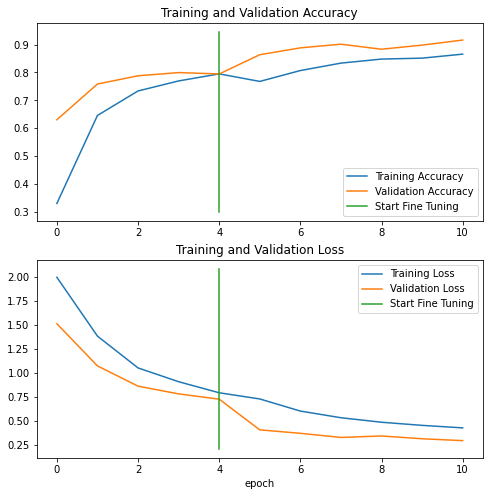

In [ ]:
# Fine-tuning diễn ra thế nào với nhiều dữ liệu hơn?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

Có vẻ dữ liệu bổ sung đã giúp ích rất nhiều! Các đường này trông rất tuyệt. Và nếu chúng ta huấn luyện lâu hơn thì chúng sẽ tiếp tục cải thiện.

## Xem dữ liệu thử nghiệm trên TensorBoard

Ngay bây giờ các kết quả thử nghiệm được phân tán rải rác khắp notebook. Nếu muốn chia sẻ chúng với người khác, họ sẽ nhận được rất nhiều biểu đồ, phép đánh giá khác nhau...đây không phải thời điểm thú vị.

Nhưng bạn biết không?

Nhờ TensorBoard callback mà chúng ta đã tạo với hàm hỗ trợ `create_tensorflow_callback()`, chúng ta đã theo dõi các thử nghiệm lập mô hình suốt thời gian qua.

Làm thế nào để upload chúng lên TensorBoard.dev và kiểm tra?

Có thể thực hiện với lệnh `tensorboard dev upload` và chuyển nó vào directory nơi các thử nghiệm được ghi lại.

> 🔑 **Lưu ý:** Bất cứ thứ gì bạn upload lên TensorBoard.dev cũng đều công khai. Nếu bạn không muốn chia sẻ nhật ký huấn luyện thì đừng upload.

In [ ]:
# Xem nhật ký tensorboard của các thử nghiệm lập mô hình transfer learning (nên là 4 mô hình)
# Upload các bản ghi TensorBoard dev
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # thoát khỏi uploader sau khi hoàn thành upload

2020-09-17 22:51:36.043126: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Data for the "graphs" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "histograms" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "hparams" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.

View your TensorBoard live at: https://tensorboard.dev/experiment/2O76kw3PQbKl0lByfg5B4w/

[2020-09-17T22:51:37] Uploader started.
[2020-09-17T22:51:4

Sau khi đã upload kết quả lên TensorBoard.dev, chúng ta có một liên kết có thể chia sẻ được dùng để xem, so sánh các thử nghiệm và chia sẻ kết quả với người khác nếu cần.

Bạn có thể xem các phiên bản ban đầu của những thử nghiệm mà chúng ta đã chạy trong notebook này ở: https://tensorboard.dev/experiment/2O76kw3PQbKl0lByfg5B4w/

> 🤔 **Câu hỏi:** Mô hình nào thực hiện tốt nhất? Tại sao bạn lại nghĩ vậy? Fine-tuning diễn ra thế nào?

Để tìm tất cả các thử nghiệm TensorBoard.dev trước đó, có thể sử dụng `tensorboard dev list`.

In [ ]:
# Xem các thử nghiệm trước đó
!tensorboard dev list

2020-09-17 22:51:48.747476: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Data for the "graphs" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "histograms" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "hparams" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/2O76kw3PQbKl0lByfg5B4w/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   2O76kw3PQbKl0lB

Có thể sử dụng lệnh sau nếu bạn muốn loại bỏ thử nghiệm trước đó (và xóa nó khỏi chế độ xem công khai):

```
tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID_TO_DELETE]```

In [ ]:
# Loại các thử nghiệm trước đó
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q

2020-09-17 22:51:53.982454: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Data for the "graphs" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "histograms" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "hparams" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
No such experiment OUbW0O3pRqqQgAphVBxi8Q. Either it never existed or it has already been deleted.


## 🛠 Bài tập thực hành
> **Lưu ý:** Các bạn cần làm phần bài tập này để chuẩn bị cho phiên review lab.

1. Viết một hàm để hiển thị ảnh từ tập dữ liệu và lớp bất kỳ (chẳng hạn: "steak", "pizza"...), trực quan hóa nó và đưa ra dự đoán sử dụng mô hình đã huấn luyện.
2. Sử dụng feature-extraction để huấn luyện mô hình transfer learning trên 10% dữ liệu Food Vision cho 10 epoch, sử dụng [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) làm base model. Dùng [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback để lưu trọng số vào file.
3. Tinh chỉnh 20 layer cuối của base model mà bạn đã huấn luyện ở 2 cho 10 epoch khác.
4. Tinh chỉnh 30 layer cuối của base model mà bạn đã huấn luyện ở 2 cho 10 epoch khác.

1/1 [==============================] - 0s 121ms/step


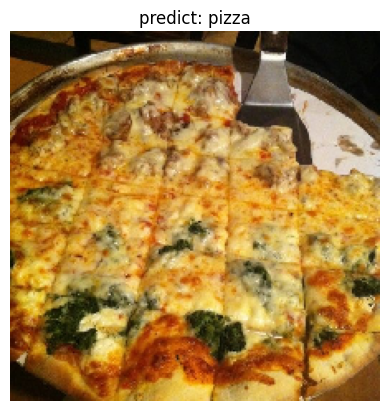

In [24]:
#1.Viết một hàm để hiển thị ảnh từ tập dữ liệu và lớp bất kỳ (chẳng hạn: "steak", "pizza"...),
    # trực quan hóa nó và đưa ra dự đoán sử dụng mô hình đã huấn luyện.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
def predict_1(path,model = model_0):
  img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224)) # đọc trong ảnh mục tiêu đã chọn
  img_ = tf.expand_dims(img, axis=0)  #mở rộng trục
  kq = model.predict(img_)
  predict_class = train_data_10_percent.class_names[np.argmax(kq)]
  plt.imshow(img) # vẽ ảnh mục tiêu
  plt.title(f"predict: {predict_class}")
  plt.axis(False); # turn-off các trục
predict_1('10_food_classes_1_percent/train/pizza/3042454.jpg')

In [40]:
#2.Sử dụng feature-extraction để huấn luyện mô hình transfer learning trên 10% dữ liệu Food Vision cho 10 epoch,
        #sử dụng tf.keras.applications.EfficientNetB0 làm base model. Dùng ModelCheckpoint callback để lưu trọng số vào file.
import tensorflow.keras.layers as layers
from tensorflow.keras.layers.experimental import preprocessing
# Tạo data augmentation stage với horizontal flipping, rotation, zoom
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # giữ cho ResNet50V2, loại với EfficientNetB0
], name ="data_augmentation")
input =  tf.keras.layers.Input(shape = (224,224,3), name="input_layer")
x = data_augmentation(input)
model_base = tf.keras.applications.EfficientNetB0(include_top=False)
model_base.trainable = False
x = model_base(x,training = False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
ouput = tf.keras.layers.Dense(10,activation = 'softmax')(x)
model_a = tf.keras.Model(input,ouput)
model_a.compile(loss = tf.keras.losses.categorical_crossentropy,optimizer= tf.keras.optimizers.Adam(),metrics='accuracy')

HH = model_a.fit(train_data_10_percent,
                                         epochs=10,
                                        validation_data=test_data,
                                        validation_steps=int(0.25 * len(test_data)), # thực hiện ít bước hơn mỗi validation (nhanh hơn)
                                     callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                               checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240419-073504
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.9116 - accuracy: 0.3827
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 104s 4s/step - loss: 1.9116 - accuracy: 0.3827 - val_loss: 1.4502 - val_accuracy: 0.6250
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.2568 - accuracy: 0.7240
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 92s 4s/step - loss: 1.2568 - accuracy: 0.7240 - val_loss: 0.9873 - val_accuracy: 0.7747
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.9691 - accuracy: 0.7787
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 142s 6s/step - loss: 0.9691 - accuracy: 0.7787 - val_loss: 0.8061 - val_accuracy: 0.8174
Epoch

In [38]:
#3.Tinh chỉnh 20 layer cuối của base model mà bạn đã huấn luyện ở 2 cho 10 epoch khác.
input =  tf.keras.layers.Input(shape = (224,224,3), name="input_layer")
x = data_augmentation(input)
model_base = tf.keras.applications.EfficientNetB0(include_top=False)
model_base.trainable = False
for i in model_base.layers[-20:]:
  i.trainable = True
x = model_base(x,training = False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
ouput = tf.keras.layers.Dense(10,activation = 'softmax')(x)
model_a = tf.keras.Model(input,ouput)
model_a.compile(loss = tf.keras.losses.categorical_crossentropy,optimizer= tf.keras.optimizers.Adam(),metrics='accuracy')

HH = model_a.fit(train_data_10_percent,
                                         epochs=10,
                                        validation_data=test_data,
                                        validation_steps=int(0.25 * len(test_data)), # thực hiện ít bước hơn mỗi validation (nhanh hơn)
                                     callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                               checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240419-065040
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.9537 - accuracy: 0.3400
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 106s 4s/step - loss: 1.9537 - accuracy: 0.3400 - val_loss: 1.3795 - val_accuracy: 0.6908
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.2627 - accuracy: 0.6933
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 98s 4s/step - loss: 1.2627 - accuracy: 0.6933 - val_loss: 0.9443 - val_accuracy: 0.8026
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.9796 - accuracy: 0.7827
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 134s 6s/step - loss: 0.9796 - accuracy: 0.7827 - val_loss: 0.7505 - val_accuracy: 0.8191
Epoch

In [39]:
#4.Tinh chỉnh 30 layer cuối của base model mà bạn đã huấn luyện ở 2 cho 10 epoch khác.
input =  tf.keras.layers.Input(shape = (224,224,3), name="input_layer")
x = data_augmentation(input)
model_base = tf.keras.applications.EfficientNetB0(include_top=False)
model_base.trainable = False
for i in model_base.layers[-30:]:
  i.trainable = True
x = model_base(x,training = False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
ouput = tf.keras.layers.Dense(10,activation = 'softmax')(x)
model_a = tf.keras.Model(input,ouput)
model_a.compile(loss = tf.keras.losses.categorical_crossentropy,optimizer= tf.keras.optimizers.Adam(),metrics='accuracy')

HH = model_a.fit(train_data_10_percent,
                                         epochs=10,
                                        validation_data=test_data,
                                        validation_steps=int(0.25 * len(test_data)), # thực hiện ít bước hơn mỗi validation (nhanh hơn)
                                     callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                               checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240419-071254
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.9993 - accuracy: 0.3253
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 105s 4s/step - loss: 1.9993 - accuracy: 0.3253 - val_loss: 1.4267 - val_accuracy: 0.6694
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.2989 - accuracy: 0.6920
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 134s 6s/step - loss: 1.2989 - accuracy: 0.6920 - val_loss: 0.9624 - val_accuracy: 0.8092
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.0116 - accuracy: 0.7560
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 97s 4s/step - loss: 1.0116 - accuracy: 0.7560 - val_loss: 0.7681 - val_accuracy: 0.8191
Epoch

## 📖 Tài liệu đọc thêm

* Đọc [tài liệu về data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) trong TensorFlow.
* Đọc [tài liệu ULMFit](https://arxiv.org/abs/1801.06146) (kỹ thuật) phần giới thiệu khái niệm về freezing và unfreezing các layer khác nhau.
* Đọc về learning rate scheduling (có một [TensorFlow callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) cho điều này), nó ảnh hưởng tới việc huấn luyện mô hình thế nào?
  * Nếu bạn huấn luyện lâu hơn, có thể bạn sẽ muốn giảm learning rate khi tới gần với đáy đồi hơn, thực hiện các bước nhỏ hơn. Hãy tưởng tượng nó như việc tìm đồng xu ở dưới sofa. Lúc đầu các chuyển động cánh tay sẽ lớn và lúc gần tới đồng xu thì chuyển động nhỏ dần.